In [1]:
# importing the necessary libraries
import pandas as pd
from geopy.distance import great_circle
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import operator
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [2]:
#Defining function for finding distance from berlin centre
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778,13.404166666666667)
    accommodation = (lat,lon)
    return great_circle(berlin_centre,accommodation).miles

In [3]:
def minmaxscaling(X):
    min_max=MinMaxScaler()
    X_minmax=pd.DataFrame(min_max.fit_transform(X),index =X.index,columns = X.columns)
    return X_minmax

In [4]:
# Defining Error Metrics Functions
rmse_dict = {}
error_metric = pd.DataFrame({'r2_train': [],'r2_test': [],'rms_train':[],'rms_test': [],'mae_train': [],'mae_test':[],'mape_train':[],'mape_test':[]})

def calc_error_metric(modelname, model, X_train_scale, y_train, X_test_scale, y_test):
    global error_metric
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    print(modelname)
    #MAE, RMS, MAPE, R2
    
    r2_train = r2_score(y_train, y_train_predicted)
    r2_test = r2_score(y_test, y_test_predicted)
    
    print('r2 = ' + str(r2_test))
    
    rms_train = sqrt(mean_squared_error(y_train, y_train_predicted))
    rms_test = sqrt(mean_squared_error(y_test, y_test_predicted))
    
    print('RMSE %f' %(rms_test))
    
    mae_train = mean_absolute_error(y_train, y_train_predicted)
    mae_test = mean_absolute_error(y_test, y_test_predicted)
        
    mape_train = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_predicted) / y_test)) * 100
        
    rmse_dict[modelname] = rms_test
        
    df_local = pd.DataFrame({'Model':[modelname],
                            'r2_train': [r2_train],
                            'r2_test': [r2_test],
                            'rms_train':[rms_train], 
                            'rms_test': [rms_test],
                            'mae_train': [mae_train],
                            'mae_test': [mae_test],
                            'mape_train':[mape_train],
                            'mape_test':[mape_test]})
        
    error_metric = pd.concat([error_metric, df_local])
    return error_metric

In [5]:
# reading csv files
df = pd.read_csv('C:/Users/vedan/Desktop/Airbnb/listings_summary.csv')

In [6]:
df_listings = df[['street','neighbourhood','city','state','zipcode','market','smart_location','country_code','country','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price','weekly_price','monthly_price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','has_availability','availability_30','availability_60','availability_90','availability_365','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license','instant_bookable','is_business_travel_ready','cancellation_policy','reviews_per_month']]

In [7]:
# checking the null values
df_listings.isnull().sum()

street                             0
neighbourhood                   1131
city                               5
state                             84
zipcode                          656
market                            63
smart_location                     0
country_code                       0
country                            0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         32
bedrooms                          18
beds                              40
bed_type                           0
amenities                          0
square_feet                    22106
price                              0
weekly_price                   18871
monthly_price                  19893
security_deposit                9361
cleaning_fee                    7146
guests_included                    0
extra_people                       0
m

In [8]:
# Selecting the final features
df_final = df_listings[['latitude','longitude','room_type','accommodates','bathrooms','bedrooms','beds','price','security_deposit','cleaning_fee','guests_included','cancellation_policy']]

In [9]:
# Eleminating Special characters
df_final['price']= df_final['price'].str.replace('$','')
df_final['security_deposit']= df_final['security_deposit'].str.replace('$','')
df_final['cleaning_fee']= df_final['cleaning_fee'].str.replace('$','')
df_final['price']= df_final['price'].str.replace(',','')
df_final['security_deposit']= df_final['security_deposit'].str.replace(',','')
df_final['cleaning_fee']= df_final['cleaning_fee'].str.replace(',','')

In [10]:
# Eliminating nulls with 0
df_final['security_deposit'] = df_final['security_deposit'].fillna('0')
df_final['cleaning_fee'] = df_final['cleaning_fee'].fillna('0')

In [11]:
df_final['security_deposit'] = pd.to_numeric(df_final['security_deposit'])
df_final['cleaning_fee'] = pd.to_numeric(df_final['cleaning_fee'])
df_final['price'] = pd.to_numeric(df_final['price'])

In [12]:
#checking the counts of property type
df_listings.property_type.value_counts()

Apartment                 20225
Condominium                 612
Loft                        460
House                       398
Serviced apartment          175
Hostel                      128
Townhouse                    99
Guest suite                  74
Bed and breakfast            64
Guesthouse                   57
Hotel                        50
Other                        47
Boutique hotel               43
Bungalow                     20
Boat                         17
Tiny house                   12
Houseboat                    11
Camper/RV                    11
Villa                        10
Pension (South Korea)         7
Aparthotel                    7
Cabin                         6
Cottage                       4
Resort                        3
Casa particular (Cuba)        2
Castle                        2
Train                         2
Tipi                          1
Island                        1
Cave                          1
Chalet                        1
Barn    

In [13]:
#only taking in account of the top 5 property counts, and eliminating the rest
property1 =pd.DataFrame(df_listings.property_type.value_counts())
property1.head()

,property_type
Apartment,20225
Condominium,612
Loft,460
House,398
Serviced apartment,175


In [14]:
prop = np.array(property1.index)
#replacing all the other property type outside top 5 with 'others' category
for i in range(6,(prop.shape[0])):
    prop_string = prop[i]
    print(prop_string)
    df_listings.property_type = df_listings.property_type.str.replace(prop_string, 'others')
df_listings = df_listings[df_listings.property_type != "Pension (South Korea)"]
df_listings = df_listings[df_listings.property_type != "Casa particular (Cuba)"]

print("\nUnique Property Types\n")
print(df_listings.property_type.unique())

Townhouse
Guest suite
Bed and breakfast
Guesthouse
Hotel
Other
Boutique hotel
Bungalow
Boat
Tiny house
Houseboat
Camper/RV
Villa
Pension (South Korea)
Aparthotel
Cabin
Cottage
Resort
Casa particular (Cuba)
Castle
Train
Tipi
Island
Cave
Chalet
Barn
In-law

Unique Property Types

['others' 'Apartment' 'Condominium' 'Loft' 'House' 'Serviced apartment'
 'Hostel']


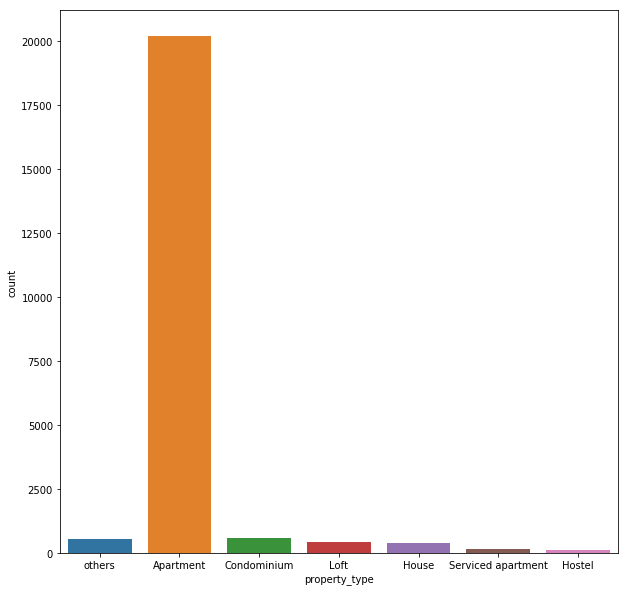

In [15]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x=df_listings.property_type)
plt.show()

In [16]:
# performing one hot encodig for room_type
df_final['room_type'] = pd.Categorical(df_final['room_type'])
df2 = pd.get_dummies(df_final['room_type'], prefix = 'room_type')
df_final = pd.concat([df_final, df2], axis=1)

In [17]:
# performing one hot encoding for cancelation_policy
df_final['cancellation_policy'] = pd.Categorical(df_final['cancellation_policy'])
df2 = pd.get_dummies(df_final['cancellation_policy'], prefix = 'cancellation_policy')
df_final = pd.concat([df_final, df2], axis=1)

In [18]:
df_final = df_final.drop(['room_type','cancellation_policy'],axis=1)
df_final.columns

Index(['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'cancellation_policy_flexible',
       'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'],
      dtype='object')

In [19]:
# replacing missing values with mean
mean_bathrooms = df_final['bathrooms'].mean()
df_final['bathrooms'] = df_final['bathrooms'].fillna(mean_bathrooms)
mean_bedrooms = df_final['bedrooms'].mean()
df_final['bedrooms'] = df_final['bedrooms'].fillna(mean_bedrooms)
mean_beds = df_final['beds'].mean()
df_final['beds'] = df_final['beds'].fillna(mean_beds)

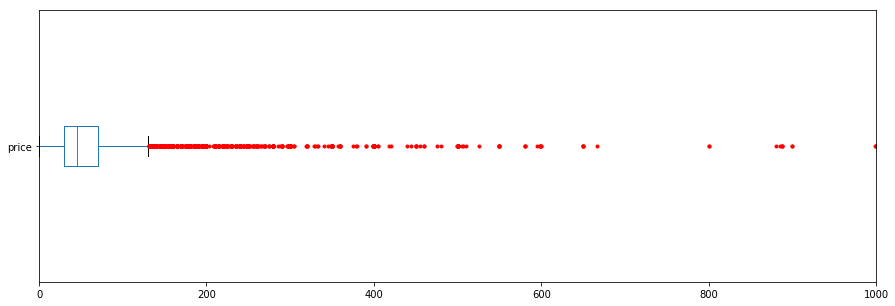

In [20]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_final['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(15,5));

In [21]:
#dropping the price which are above $400, and less than $0. Outliers
df_final.drop(df_final[ (df_final.price > 400) | (df_final.price == 0) ].index, axis=0, inplace=True)

In [22]:
#converting the latitude and longitude to distance in miles, relative to the center of berlin
df_final= df_final.assign(distance=df_final.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1))
df_final = df_final.drop(["latitude","longitude"],axis=1)

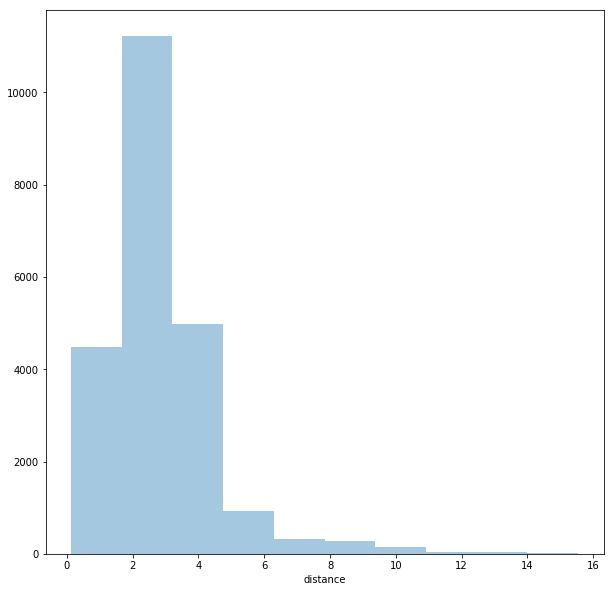

In [23]:
plt.figure(figsize=(10,10))
ax = sns.distplot(df_final["distance"], bins=10, kde=False)
plt.show()

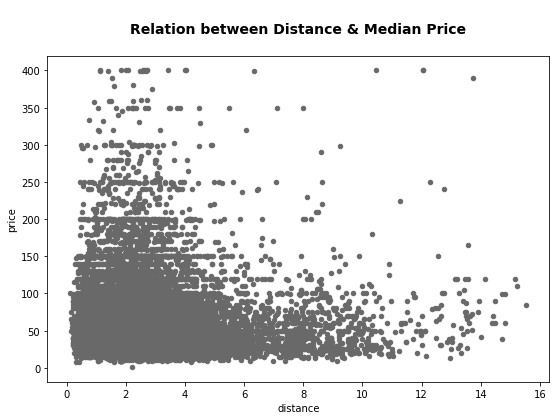

In [24]:
df_final.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');
plt.show()

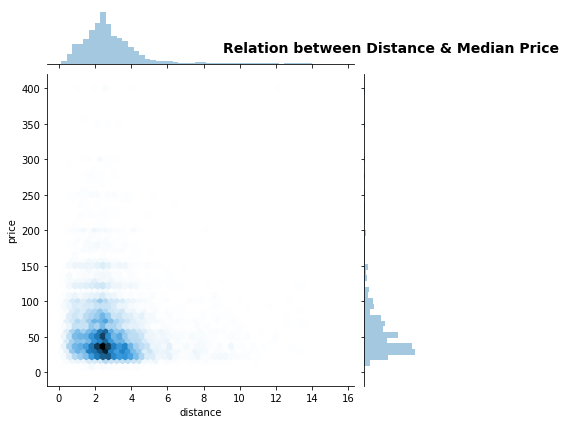

In [25]:
sns.jointplot(x=df_final["distance"], y=df_final["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');
plt.show()

In [26]:
df_final.isnull().sum()

accommodates                                       0
bathrooms                                          0
bedrooms                                           0
beds                                               0
price                                              0
security_deposit                                   0
cleaning_fee                                       0
guests_included                                    0
room_type_Entire home/apt                          0
room_type_Private room                             0
room_type_Shared room                              0
cancellation_policy_flexible                       0
cancellation_policy_moderate                       0
cancellation_policy_strict_14_with_grace_period    0
cancellation_policy_super_strict_30                0
cancellation_policy_super_strict_60                0
distance                                           0
dtype: int64

In [27]:
df_final['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [28]:
# defining the features
X = df_final.drop(['price'],axis=1)
X = minmaxscaling(X)

In [29]:
# defining the target
y = df_final['price']

In [30]:
# Spliting data into train test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

<Figure size 432x288 with 0 Axes>

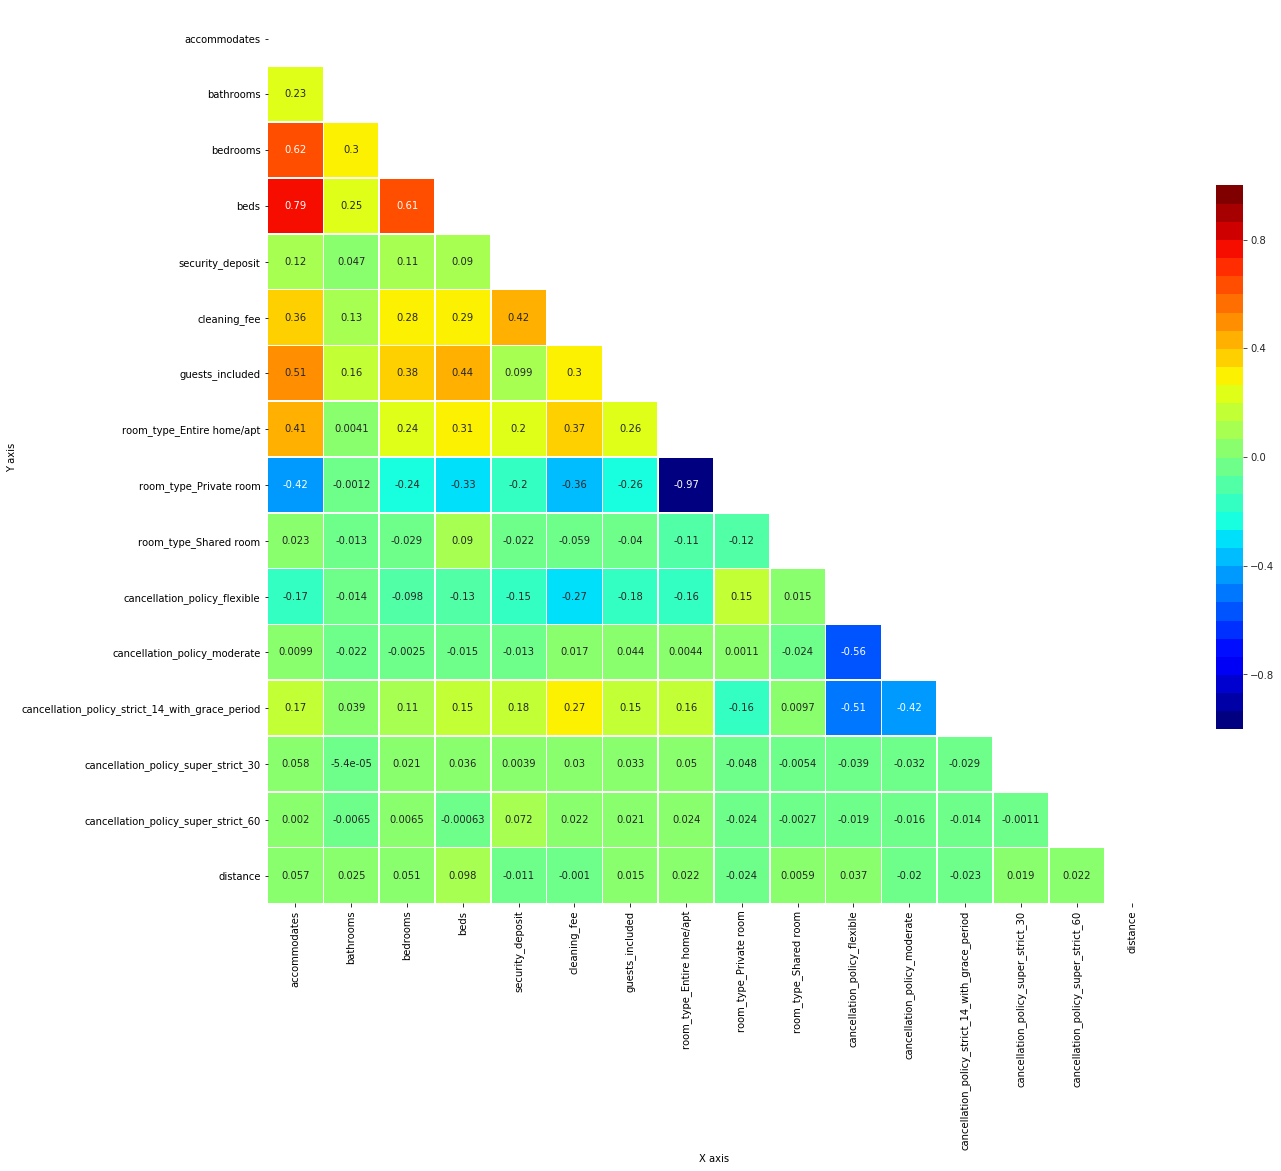

In [31]:
# correlation matrix
corre = X.corr()
mask = np.zeros_like(corre)
mask[np.triu_indices_from(mask)] = True
cmap = plt.cm.get_cmap('jet',30)
fig = plt.figure()
f,ax = plt.subplots(figsize=(20,20))
fig.suptitle('HeaMap')
with sns.axes_style("white"):
  ax = sns.heatmap(corre, mask=mask, cmap=cmap, annot=True, vmax=1.0, vmin=-1.0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.xlabel("X axis")
  plt.ylabel("Y axis")
  
plt.savefig("HeatMap.png")
plt.show()

# Linear Regression

In [32]:
pipe_lr = Pipeline([('clf', LinearRegression(normalize=True))])
grid_params_lr =[{}]
gs_lr = GridSearchCV(estimator=pipe_lr, param_grid=grid_params_lr, cv=10) 
gs_lr.fit(X_train, y_train)
calc_error_metric('Regression', gs_lr, X_train, y_train, X_test, y_test)

'''
pkl_linear = "LinearRegression.pkl"
with open(pkl_linear, 'wb') as file:  
    pickle.dump(gs_lr, file)
'''

Regression
r2 = 0.48265244705024746
RMSE 30.858726


'\npkl_linear = "LinearRegression.pkl"\nwith open(pkl_linear, \'wb\') as file:  \n    pickle.dump(gs_lr, file)\n'

# Random Forest

In [33]:
pipe_rf = Pipeline([('rf', RandomForestRegressor(n_estimators=115,max_features=6,random_state=42))])
grid_params_rf = [{}]
gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=grid_params_rf, cv=10)
gs_rf.fit(X_train, y_train)
calc_error_metric('RandomForest', gs_rf, X_train, y_train, X_test, y_test)

'''
pkl_random = "RandomForest.pkl"
with open(pkl_random, 'wb') as file:  
    pickle.dump(gs_rf, file)
'''

RandomForest
r2 = 0.5183051776780849
RMSE 29.776441


'\npkl_random = "RandomForest.pkl"\nwith open(pkl_random, \'wb\') as file:  \n    pickle.dump(gs_rf, file)\n'

# Gradient Booster

In [34]:
pipe_gbm = Pipeline([('gbm', GradientBoostingRegressor(n_estimators=300,learning_rate= 0.1,max_features=1.0,random_state=42))])
grid_params_gbm =[{}]
gs_gbm = GridSearchCV(estimator=pipe_gbm, param_grid=grid_params_gbm, cv=10)
gs_gbm.fit(X_train, y_train)
calc_error_metric('GradientBoostingRegressor', gs_gbm, X_train, y_train, X_test, y_test)

'''
pkl_gradient = "GradientBoosting.pkl"
with open(pkl_gradient, 'wb') as file:  
    pickle.dump(gs_gbm, file)
'''

GradientBoostingRegressor
r2 = 0.5465365822286876
RMSE 28.890691


'\npkl_gradient = "GradientBoosting.pkl"\nwith open(pkl_gradient, \'wb\') as file:  \n    pickle.dump(gs_gbm, file)\n'

# XGBoost

In [35]:
import re
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train,y_train)
calc_error_metric('XGBoost', xg_reg, X_train, y_train, X_test, y_test)

XGBoost
r2 = 0.5391497261463819
RMSE 29.125053


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Regression,19.330860,19.262170,39.087746,38.344646,0.482652,0.454490,30.858726,30.954697
0,RandomForest,18.844510,7.035132,38.587230,14.023040,0.518305,0.927963,29.776441,11.248704
0,GradientBoostingRegressor,18.160019,17.187743,36.762806,34.865982,0.546537,0.591744,28.890691,26.778809
0,XGBoost,18.299371,17.951326,37.158057,36.072180,0.539150,0.536971,29.125053,28.518662


# Light Gradient Boosting

In [37]:
import re
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
   
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20)

calc_error_metric('LightGradientBoosting', gbm, X_train, y_train, X_test, y_test)

LightGradientBoosting
r2 = 0.43525114318407443
RMSE 32.241444


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Regression,19.330860,19.262170,39.087746,38.344646,0.482652,0.454490,30.858726,30.954697
0,RandomForest,18.844510,7.035132,38.587230,14.023040,0.518305,0.927963,29.776441,11.248704
0,GradientBoostingRegressor,18.160019,17.187743,36.762806,34.865982,0.546537,0.591744,28.890691,26.778809
0,XGBoost,18.299371,17.951326,37.158057,36.072180,0.539150,0.536971,29.125053,28.518662
0,LightGradientBoosting,20.484171,20.183204,44.737018,44.037210,0.435251,0.435377,32.241444,31.492296


### Understanding XGBoost is best algorithm, we apply Hyper-parameter tuning

# Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 15, 20],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

booster_grid_search = GridSearchCV(xg_reg, param_grid, cv=3, n_jobs=-1)
booster_grid_search.fit(X_train, y_train)
print(booster_grid_search.best_params_)
calc_error_metric('XGBoostGridSearch', booster_grid_search, X_train, y_train, X_test, y_test)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 20}
XGBoostGridSearch
r2 = 0.48767169968547397
RMSE 30.708668


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Regression,19.330860,19.262170,39.087746,38.344646,0.482652,0.454490,30.858726,30.954697
0,RandomForest,18.844510,7.035132,38.587230,14.023040,0.518305,0.927963,29.776441,11.248704
0,GradientBoostingRegressor,18.160019,17.187743,36.762806,34.865982,0.546537,0.591744,28.890691,26.778809
0,XGBoost,18.299371,17.951326,37.158057,36.072180,0.539150,0.536971,29.125053,28.518662
0,LightGradientBoosting,20.484171,20.183204,44.737018,44.037210,0.435251,0.435377,32.241444,31.492296
0,XGBoostGridSearch,18.051879,17.258589,31.920594,30.424092,0.487672,0.519431,30.708668,29.053807


In [39]:
import re
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
booster = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, 
                           max_depth=6, n_estimators=150)
booster.fit(X_train, y_train)
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

calc_error_metric('XGBoostRegressor', booster, X_train, y_train, X_test, y_test)

XGBoostRegressor
r2 = 0.5530941300285899
RMSE 28.681036


,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Regression,19.330860,19.262170,39.087746,38.344646,0.482652,0.454490,30.858726,30.954697
0,RandomForest,18.844510,7.035132,38.587230,14.023040,0.518305,0.927963,29.776441,11.248704
0,GradientBoostingRegressor,18.160019,17.187743,36.762806,34.865982,0.546537,0.591744,28.890691,26.778809
0,XGBoost,18.299371,17.951326,37.158057,36.072180,0.539150,0.536971,29.125053,28.518662
0,LightGradientBoosting,20.484171,20.183204,44.737018,44.037210,0.435251,0.435377,32.241444,31.492296
0,XGBoostGridSearch,18.051879,17.258589,31.920594,30.424092,0.487672,0.519431,30.708668,29.053807
0,XGBoostRegressor,17.954106,16.460591,36.422296,33.835486,0.553094,0.632313,28.681036,25.413504


# Cross validation

In [49]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)
params = {'colsample_bytree':0.7, 'gamma':0.1, 'learning_rate':0.05, 'max_depth':6, 'n_estimators':150}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

cv_results.head()
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
145,24.591215,0.493383,29.494862,0.997155
146,24.582574,0.496354,29.494918,0.997378
147,24.563884,0.488915,29.495542,1.000269
148,24.554230,0.486517,29.493453,1.001797
149,24.543312,0.488186,29.493047,1.001417


In [50]:
#### Calculate best model
best_model =  min(rmse_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)
#### Write the error
error_metric.to_csv('Error_metrics.csv')

Best Model is  XGBoostRegressor
